In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a df for easier access
cat_df = catalog.df

In [3]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: Selecting CMIP for historical and ScenarioMIP for future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Models selected earlier
source_id = ['CanESM5']

# experiment_id: I chose the historical data and the ssp370 projection as my two time experimental configurations
experiment_ids = ['historical', 'ssp370']

# member_id: Changed the ensemble member here because there was more data available
member_id = 'r10i1p1f1'

# table_id: Selecting monthly atmospheric data, which is the table that precipitation is stored in. 
table_id = 'Amon' 

# variable_id:  surface air temperature
variable_id = ['tas', 'pr'] 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
1,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
2,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


In [5]:
# Read in the historical data file for GFDL
hist_tas_can = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})
hist_pr_can = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

# Read in 370 projections for CAN
tas_can_370 = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True})
pr_can_370 = xr.open_zarr(res.df['zstore'][3], storage_options={'anon': True})

In [6]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [8]:
# Concatenate historical and future projection data
can_tas = xr.concat([hist_tas_can, tas_can_370], dim="time")

can_pr = xr.concat([hist_pr_can, pr_can_370], dim="time")

In [12]:
# Define region of interest
lat_min, lat_max = -11, 28
lon_min, lon_max = 92, 141

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_lat = (can_tas.lat >= lat_min) & (can_tas.lat <= lat_max)
tas_lon = (can_tas.lon >= lon_min) & (can_tas.lon <= lon_max)

# Define logical mask 2: True when lat/lon inside the valid ranges, False elsewhere
pr_lat = (can_pr.lat >= lat_min) & (can_pr.lat <= lat_max)
pr_lon = (can_pr.lon >= lon_min) & (can_pr.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_E = can_tas.where(tas_lat & tas_lon, drop=True)

pr_E = can_pr.where(pr_lat & pr_lon, drop=True)

# Apply area weights
tas_weighted = weights(tas_E)
pr_weighted = weights(pr_E)

# Compute annually averaged, regionally averaged time series
tas_annual = tas_weighted.mean(dim=["lat", "lon"]).resample(time="1Y").mean()
pr_annual = pr_weighted.mean(dim=["lat", "lon"]).resample(time="1Y").mean()

# Save tas variable
tas_annual = tas_annual["tas"] - 273.15
pr_annual = pr_annual["pr"]

# Convert time to datetime64 format
time = tas_annual.time.astype('datetime64[ns]')
time2 = pr_annual.time.astype('datetime64[ns]')

In [15]:
# Calculate the annual mean precipitation
mean_tas_can = tas_annual.groupby('time.year').mean()

# Calculate best-fit parameters for the linear polynomial fit of precipitation to year
poly_tas_can = np.polyfit(mean_tas_can.year, mean_tas_can, 1)

# Generate a polynomial object using those best-fit parameters
trend_tas_can = np.poly1d(poly_tas_can) 

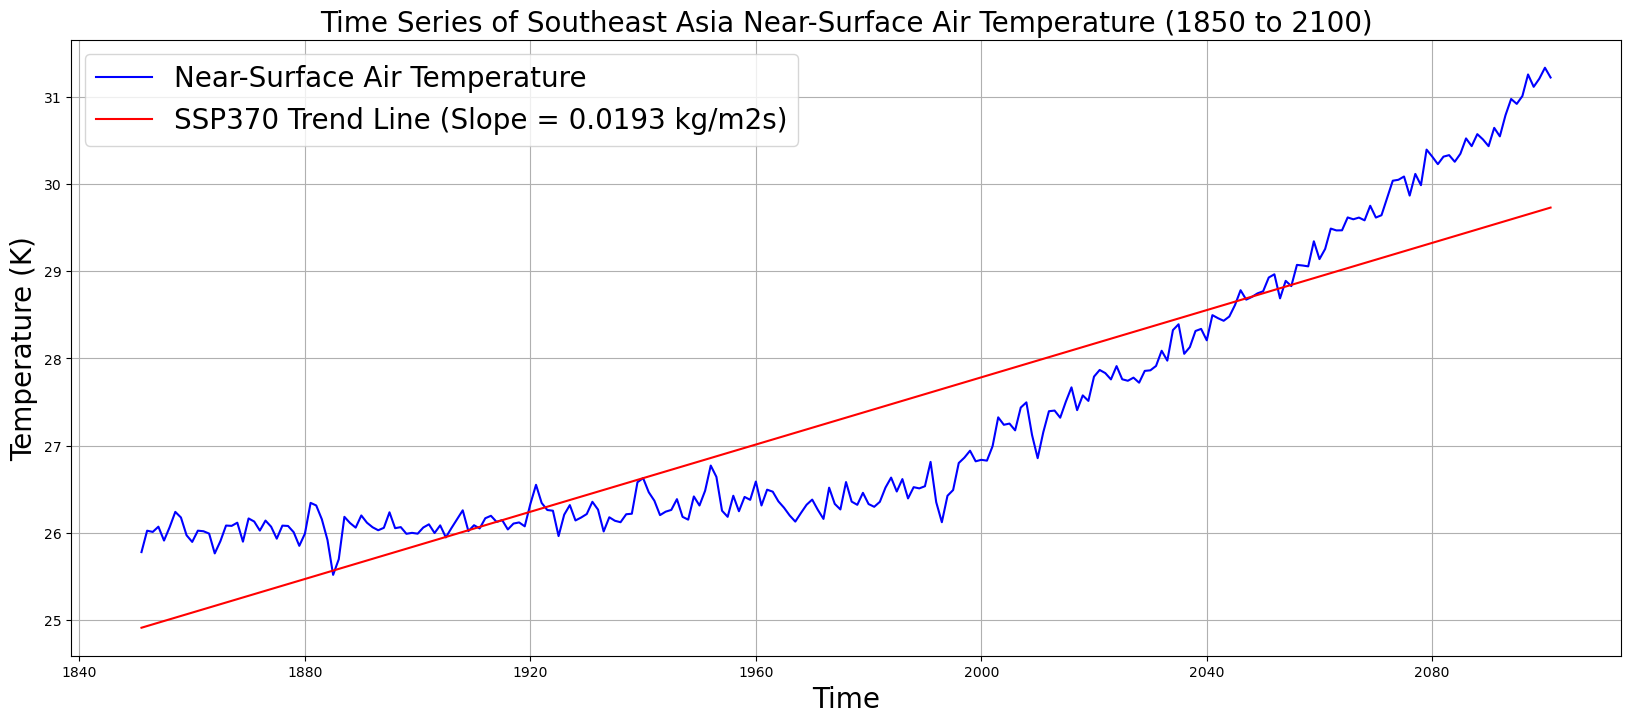

In [18]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the time series
ax.plot(time, tas_annual, label="Near-Surface Air Temperature", color="b")
ax.plot(time, trend_tas_can(mean_tas_can.year), color='red', label=f'SSP370 Trend Line (Slope = {poly_tas_can[0]:.4f} kg/m2s)')

# Add title and labels
ax.set_title("Time Series of Southeast Asia Near-Surface Air Temperature (1850 to 2100)", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add grid
ax.grid()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the time series
ax.plot(time, pr_annual, label="Near-Surface Air Temperature", color="b")
ax.plot(time, trend_tas_can(mean_tas_can.year), color='red', label=f'SSP370 Trend Line (Slope = {poly_tas_can[0]:.4f} kg/m2s)')

# Add title and labels
ax.set_title("Time Series of Southeast Asia Near-Surface Air Temperature (1850 to 2100)", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add grid
ax.grid()

plt.show()